<a href="https://colab.research.google.com/github/abhimanyuA3/Anomaly-Detection/blob/main/22am003_Anomaly_Detection_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # Make sure to import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [24]:
# Load Dataset
def load_dataset():
    df = pd.read_csv('/content/HeartDiseaseTrain-Test.csv')
    return df

# Load and display the first few rows of the dataset
df = load_dataset()
print(df.head())

   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1 

In [25]:
# Preprocess Data: Encode Categorical Features
def preprocess_data(df):
    # Convert categorical columns to numeric (one-hot encoding or label encoding)
    df = pd.get_dummies(df, drop_first=True)
    return df

In [26]:
# Apply preprocessing
df = preprocess_data(df)
print("Data after encoding categorical features:\n", df.head())

Data after encoding categorical features:
    age  resting_blood_pressure  cholestoral  Max_heart_rate  oldpeak  target  \
0   52                     125          212             168      1.0       0   
1   53                     140          203             155      3.1       0   
2   70                     145          174             125      2.6       0   
3   61                     148          203             161      0.0       0   
4   62                     138          294             106      1.9       0   

   sex_Male  chest_pain_type_Atypical angina  \
0      True                            False   
1      True                            False   
2      True                            False   
3      True                            False   
4     False                            False   

   chest_pain_type_Non-anginal pain  chest_pain_type_Typical angina  ...  \
0                             False                            True  ...   
1                             False

In [27]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Handle missing values (fill with mean, median, or drop)
# Here, we're using SimpleImputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

Missing values in each column:
 age                                         0
resting_blood_pressure                      0
cholestoral                                 0
Max_heart_rate                              0
oldpeak                                     0
target                                      0
sex_Male                                    0
chest_pain_type_Atypical angina             0
chest_pain_type_Non-anginal pain            0
chest_pain_type_Typical angina              0
fasting_blood_sugar_Lower than 120 mg/ml    0
rest_ecg_Normal                             0
rest_ecg_ST-T wave abnormality              0
exercise_induced_angina_Yes                 0
slope_Flat                                  0
slope_Upsloping                             0
vessels_colored_by_flourosopy_One           0
vessels_colored_by_flourosopy_Three         0
vessels_colored_by_flourosopy_Two           0
vessels_colored_by_flourosopy_Zero          0
thalassemia_No                              0
th

In [28]:
# Data Normalization (Z-score)
def normalize_data(df):
    scaler = StandardScaler()
    normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return normalized_df

In [29]:
# Normalize the data
normalized_df = normalize_data(df_imputed)
print("Normalized Data:\n", normalized_df.head())

Normalized Data:
         age  resting_blood_pressure  cholestoral  Max_heart_rate   oldpeak  \
0 -0.268437               -0.377636    -0.659332        0.821321 -0.060888   
1 -0.158157                0.479107    -0.833861        0.255968  1.727137   
2  1.716595                0.764688    -1.396233       -1.048692  1.301417   
3  0.724079                0.936037    -0.833861        0.516900 -0.912329   
4  0.834359                0.364875     0.930822       -1.874977  0.705408   

     target  sex_Male  chest_pain_type_Atypical angina  \
0 -1.026698  0.661504                        -0.441179   
1 -1.026698  0.661504                        -0.441179   
2 -1.026698  0.661504                        -0.441179   
3 -1.026698  0.661504                        -0.441179   
4 -1.026698 -1.511706                        -0.441179   

   chest_pain_type_Non-anginal pain  chest_pain_type_Typical angina  ...  \
0                         -0.619085                        1.030715  ...   
1           

In [30]:
# Anomaly Detection functions here
# Z-score Based Anomaly Detection
def z_score_anomaly_detection(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    anomalies = (z_scores > threshold).any(axis=1)
    return anomalies

In [31]:
# Mahalanobis Distance Based Anomaly Detection
def mahalanobis_anomaly_detection(df):
    mean = df.mean().values
    cov_matrix = np.cov(df.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    distances = df.apply(lambda row: mahalanobis(row, mean, inv_cov_matrix), axis=1)
    threshold = np.percentile(distances, 97.5)
    anomalies = distances > threshold
    return anomalies

In [32]:
# Local Outlier Factor (LOF) Anomaly Detection
def lof_anomaly_detection(df, n_neighbors=20):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    labels = lof.fit_predict(df)
    anomalies = labels == -1
    return anomalies

In [33]:
# Isolation Forest Anomaly Detection
def isolation_forest_anomaly_detection(df):
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    labels = iso_forest.fit_predict(df)
    anomalies = labels == -1
    return anomalies

In [34]:
# One-Class SVM Anomaly Detection
def one_class_svm_anomaly_detection(df):
    oc_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
    labels = oc_svm.fit_predict(df)
    anomalies = labels == -1
    return anomalies

In [35]:
# Apply Anomaly Detection Methods
z_anomalies = z_score_anomaly_detection(normalized_df)
print(f"Z-score detected {z_anomalies.sum()} anomalies.")

Z-score detected 209 anomalies.


In [36]:
m_anomalies = mahalanobis_anomaly_detection(normalized_df)
print(f"Mahalanobis Distance detected {m_anomalies.sum()} anomalies.")

Mahalanobis Distance detected 25 anomalies.


In [37]:
lof_anomalies = lof_anomaly_detection(normalized_df)
print(f"LOF detected {lof_anomalies.sum()} anomalies.")

LOF detected 20 anomalies.


In [38]:
iso_forest_anomalies = isolation_forest_anomaly_detection(normalized_df)
print(f"Isolation Forest detected {iso_forest_anomalies.sum()} anomalies.")

Isolation Forest detected 50 anomalies.


In [39]:
svm_anomalies = one_class_svm_anomaly_detection(normalized_df)
print(f"One-Class SVM detected {svm_anomalies.sum()} anomalies.")

One-Class SVM detected 285 anomalies.


Evaluation Metrics for Anomaly Detection Methods:
                  Precision    Recall  Accuracy
Z-score            0.038278  0.131148  0.752195
Mahalanobis        0.000000  0.000000  0.916098
LOF                0.000000  0.000000  0.920976
Isolation Forest   0.020000  0.016393  0.893659
One-Class SVM      0.059649  0.278689  0.695610


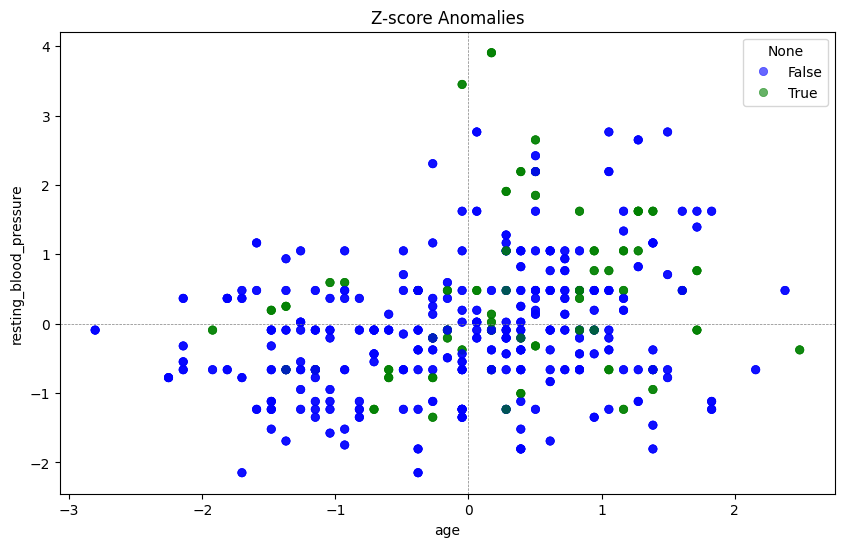

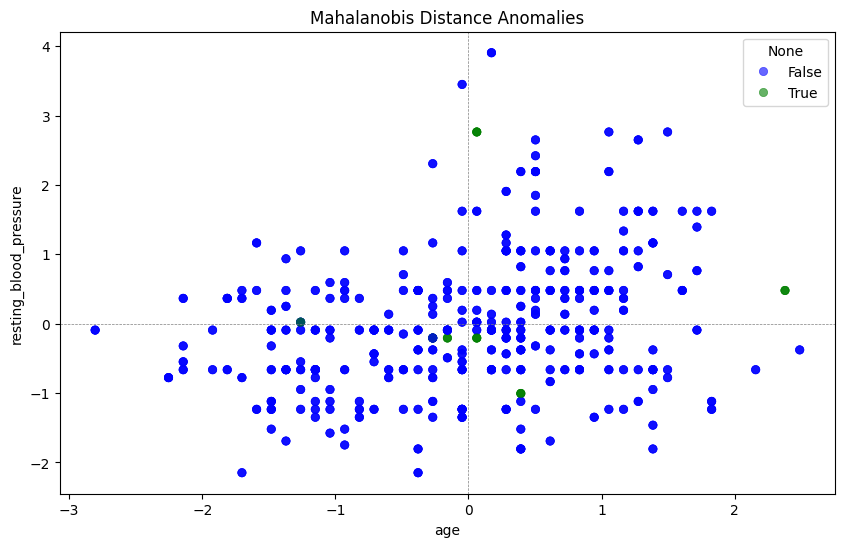

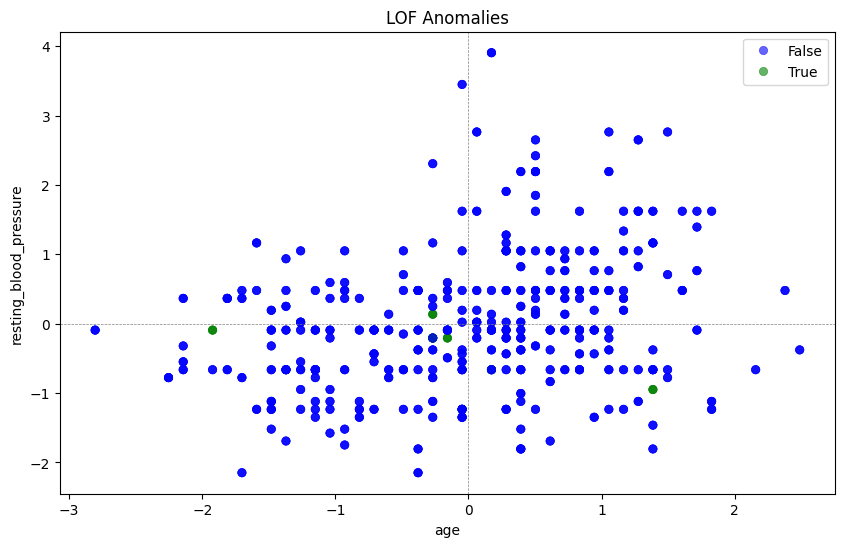

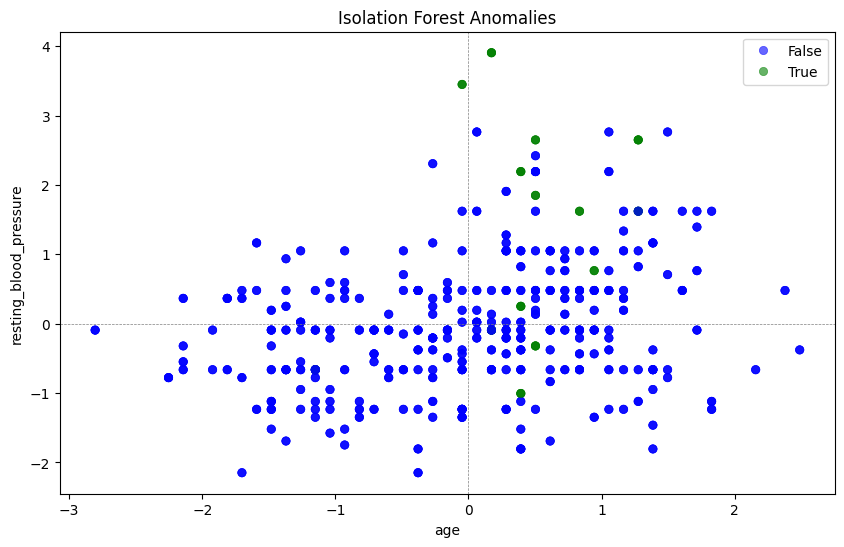

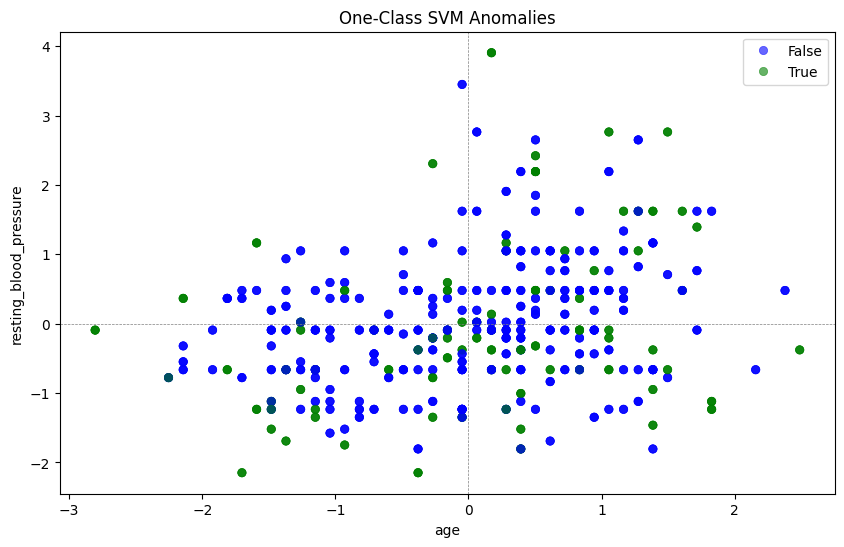

In [41]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Function to calculate evaluation metrics
def evaluate_metrics(true_labels, detected_anomalies):
    precision = precision_score(true_labels, detected_anomalies, zero_division=0)
    recall = recall_score(true_labels, detected_anomalies, zero_division=0)
    accuracy = accuracy_score(true_labels, detected_anomalies)
    return precision, recall, accuracy

# Generate synthetic labels for demonstration (1 for anomalies, 0 for normal points)
# In practice, you would replace this with your actual labels if available.
true_labels = np.random.choice([0, 1], size=len(normalized_df), p=[0.95, 0.05])

# Dictionary to store results
results = {
    'Z-score': evaluate_metrics(true_labels, z_anomalies),
    'Mahalanobis': evaluate_metrics(true_labels, m_anomalies),
    'LOF': evaluate_metrics(true_labels, lof_anomalies),
    'Isolation Forest': evaluate_metrics(true_labels, iso_forest_anomalies),
    'One-Class SVM': evaluate_metrics(true_labels, svm_anomalies)
}

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results, index=['Precision', 'Recall', 'Accuracy']).T

# Display results
print("Evaluation Metrics for Anomaly Detection Methods:")
print(results_df)

# Visualization of Anomalies
# Function to visualize anomalies
def visualize_anomalies(df, detected_anomalies, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1],
                     hue=detected_anomalies, palette=
                        {True: 'green', False: 'blue'},
                            alpha=0.6, edgecolor=None)
    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.axhline(0, color='grey', lw=0.5, ls='--')
    plt.axvline(0, color='grey', lw=0.5, ls='--')
    plt.show()

# Visualize anomalies for each method
visualize_anomalies(normalized_df, z_anomalies, "Z-score Anomalies")
visualize_anomalies(normalized_df, m_anomalies, "Mahalanobis Distance Anomalies")
visualize_anomalies(normalized_df, lof_anomalies, "LOF Anomalies")
visualize_anomalies(normalized_df, iso_forest_anomalies, "Isolation Forest Anomalies")
visualize_anomalies(normalized_df, svm_anomalies, "One-Class SVM Anomalies")